# Escuela Politécnica Nacional

### Objetivos

Este proyecto tiene como objetivo medir el tiempo promedio que los estudiantes de la EPN que ingresarone el semestre 2012-A (pertenecientes a la primera promoción del SENECYT)se tardaron en culminar su carrera y encontrar si existe una relación entre la carrera y el tiempo de graduación.
Se debe tener en cuenta que como se trabaja con la lista de planes de tesis, los estudiantes considerados en el anális son solo los que se graduan mediante el proceso de titulación por proyecto.

Librerías utilizadas

In [1]:
import tabula
import pandas as pd
from datetime import datetime
import math

### Parámetros y configuraciones

In [2]:
FILE_PATH_STUDENT = "inputs/APROBADOS INGENIERIA_2012.pdf"
FILE_PATH_STUDENT_HTML = "inputs/planesTesis.html"
FILE_PATH_STUDENTS_CSV = "epnStudents2021.csv"

## Extracción

Para realizar este análisis, se toma información de dos fuentes: 
- Lista de estudiantes aprobados para inicar el prepólitecnico en el semestre 2012 - A en formato PDF 
-  Lista de todos los planes aprovados disponible en la página del saew [saew](https://saew.epn.edu.ec/SAETESIS/BusquedaPlanTesis.aspx) en formato HTML

### Extración de información de estudiantes aprovados para el 2012-A en formato PDF

Leer información del pdf y convertir en archivo CSV

In [3]:
def getInfoFromPdf():
    tabula.convert_into(FILE_PATH_STUDENT, 'epnStudents2021.csv', pages='all')

Método para generar el dataset a partir un CSV

In [4]:
def getDatasetFromCSVFile(file_path_param):
    data_set = pd.read_csv(FILE_PATH_STUDENTS_CSV, encoding = 'latin-1')
    return data_set

Método para generar el correo electrónico de los estudiantes, este campo será utilizado para hacer match
con el otro dataset

In [5]:
def addEmail(df):
    names = df['NOMBRES']
    apellidos = df['APELLIDOS']

    # Generar los correos electrónicos
    correos = []
    for nombre, apellido in zip(names, apellidos):
        nombre_partes = nombre.lower().split()
        apellido_partes = apellido.lower().split()

        # Construir el correo electrónico
        #
        correo = f"{nombre_partes[0]}.{apellido_partes[0]}@epn.edu.ec"
        correos.append(correo)

    df['Email'] = correos
    return df

Método que retorna un data set con la información <br>
[Nombre , Carrera, Email]

In [6]:
def getInfo2012Students():
    getInfoFromPdf()
    info_students_from_pdf = getDatasetFromCSVFile(FILE_PATH_STUDENTS_CSV)
    info_studens_with_email = addEmail(info_students_from_pdf)
    return info_studens_with_email
    

In [7]:
students_2012_info = getInfo2012Students()

In [8]:
#print(students_2012_info)

### Extración de información los planes de proyecto de titulación en formato HTML

Método para sacar la info del html V2

Metodo para tomar solo las columnas necesaraias

In [9]:
def generar_dataframe(datos, columnas_necesarias):
    df = pd.DataFrame(datos, columns=columnas_necesarias)
    return df

In [10]:
def getEpnMails(email_str):
    all_emails = list(map(lambda email: email.replace(";",""), email_str.split()))
    epn_mails = list(filter(lambda email: "@epn.edu.ec" in email, all_emails))
    return ' '.join(epn_mails)

In [11]:
def getInfo(df):
    return generar_dataframe(df, ['Carrera', 'FecGradoOral', 'Email'])

Método que genera un dataFrame solo con los correos de la EPN

In [12]:
def getOnlyEpnMails(df):
    data_frame_all_emails = getInfo(df)
    email_col = data_frame_all_emails['Email']
    epn_email_col = []
    for emails in email_col:
        epn_mails = getEpnMails(emails)
        epn_email_col.append(epn_mails)
    
    data_frame_all_emails['EpnEmails'] = epn_email_col
    return data_frame_all_emails

Todo: Lo que hay que hacer es: 
1 . Generar un nuevo dataFrame
2. Las filas que ingresan directamente son las que tienen un solo correo
3. Las filas que tiene mas de un correo se debe duplicar, y cada nueva fila debe tener solo un correo de los anteriores

In [13]:
dataframes = pd.read_html(FILE_PATH_STUDENT_HTML)
students_and_tesis = getOnlyEpnMails(dataframes[0])



Método que valida si hay más de dos correos en la columa 'EpnEmails', replica la información y deja un solo correo

In [14]:
def getUniqueEmail(df):
    df_destino = pd.DataFrame()
    for index, row in df.iterrows():
        epn_emails = row['EpnEmails'].split(' ')
        epn_emails = [email.strip() for email in epn_emails]
        if len(epn_emails) == 1:
            fila = df.iloc[index]
            fila['Epn_mail_unique'] = str(epn_emails[0])
            df_destino = pd.concat([df_destino, fila.to_frame().T])
        else:
            for idx, epn_mail in enumerate(epn_emails):
                fila = df.iloc[index]
                fila['Epn_mail_unique'] = str(epn_mail)
                df_destino = pd.concat([df_destino, fila.to_frame().T])

    return df_destino
    

In [15]:
df3 = getUniqueEmail(students_and_tesis)

In [16]:
# print(df3)

-------

In [17]:
# print(students_and_tesis)

## Transformación

Para el proceso de transformación se procede a intersecar los dos dataframes, mediante el correo institucional

In [18]:
def combinar_dataframes(df1, df2):
    nuevo_df = pd.merge(df1, df2, left_on='Email', right_on='Epn_mail_unique')
    return nuevo_df

Método que genera un nuevo dataFrame realizando una intersección entre los dos dataFrames en base al campo email

In [19]:
def generar_dataframe_interseccion(df1, df2):
    # Obtiene los correos electrónicos únicos en ambos DataFrames
    emails_df1 = set(df1['Email'])
    emails_df2 = set(df2['Epn_mail_unique'])
    
    
    # Encuentra los correos electrónicos que se repiten en ambos DataFrames
    emails_repetidos = list(emails_df1.intersection(emails_df2))
    
    # Filtra los DataFrames originales utilizando los correos electrónicos repetidos
    df1_interseccion = df1[df1['Email'].isin(emails_repetidos)]
    df2_interseccion = df2[df2['Epn_mail_unique'].isin(emails_repetidos)]
    
    # Crea un nuevo DataFrame con los valores que se repiten en ambos DataFrames
    dataframe_interseccion = pd.concat([df1_interseccion, df2_interseccion], ignore_index=True)
    
    return dataframe_interseccion

In [20]:
merge_info = combinar_dataframes(students_2012_info,df3)

In [21]:
# print(merge_info.iloc[0])

Método que transforma la fecha

In [22]:
def convertir_fecha(cadena_fecha):
    formato = "%d/%m/%Y %H:%M:%S"
    fecha = datetime.strptime(cadena_fecha, formato)
    return fecha

Calular el tiempo

In [23]:
def restar_fechas(fecha1, fecha2):
    formato = '%Y-%m-%d %H:%M:%S'
    
    # Convertir las cadenas a objetos datetime
    fecha1_dt = datetime.strptime(fecha1, formato)
    fecha2_dt = datetime.strptime(fecha2, formato)
    
    # Calcular la diferencia de tiempo
    diferencia = fecha2_dt - fecha1_dt
    
    # Calcular la diferencia en años
    diferencia_anios = diferencia.days / 365.25
    
    # Retornar la diferencia en años
    return diferencia_anios


Método que toma le fecha en la que se registró la defensa de grado oral 'FecGradoOral' y se procede a calcular el tiempo transcurrido desde 2012


In [24]:
def calcular_anios(fecha1, fecha2):
    anios = fecha1.year - fecha2.year
    if fecha1.month < fecha2.month or (fecha1.month == fecha2.month and fecha1.day < fecha2.day):
        anios -= 1
    return anios

In [25]:
def add_elapsed_time_column(df):
    # Constantes
    formato = "%d/%m/%Y %H:%M:%S"
    date_time_2012 = datetime(2012, 1, 1, 0, 0, 0)
    
    oral_defense_date_string = df['FecGradoOral']
    elapsed_date_from_2012 = []
    
    for line in oral_defense_date_string:
        if isinstance(line, str):
            fecha_datetime = datetime.strptime(line, formato)
            elapsed_time = calcular_anios(fecha_datetime, date_time_2012)
            elapsed_date_from_2012.append(elapsed_time)
        else:
            elapsed_date_from_2012.append(0)
    
    df['TiempoGraduación'] = elapsed_date_from_2012
    return df
            

In [54]:
print(merge_info)

            APELLIDOS           NOMBRES  \
0       ABARCA ROBLES       JUAN DANIEL   
1     AGUILAR ALVAREZ    SANDRA NATHALY   
2     AGUILAR ALVAREZ    SANDRA NATHALY   
3    AGUILAR ENRÍQUEZ  MIGUEL ALEJANDRO   
4       AGUIRRE CUEVA  KLEBER ALEXANDER   
..                ...               ...   
347  YAGUANA VILATUÑA     DAYANA PAMELA   
348      YAMBAY TAPIA   DIEGO ALEJANDRO   
349        YAPO MONTA  YADIRA ELIZABETH   
350      YEROVI USIÑA     JAIME GUSTAVO   
351       ZURITA YUGS      KEVIN JAVIER   

                                               CARRERA  \
0                            INGENIERIA AGROINDUSTRIAL   
1        INGENIERIA ELECTRONICA Y REDES DE INFORMACION   
2        INGENIERIA ELECTRONICA Y REDES DE INFORMACION   
3                                           MATEMATICA   
4        INGENIERIA ELECTRONICA Y REDES DE INFORMACION   
..                                                 ...   
347                               INGENIERIA GEOLOGICA   
348                

In [64]:
clean_info = add_elapsed_time_column(merge_info)
print(clean_info)

            APELLIDOS           NOMBRES  \
0       ABARCA ROBLES       JUAN DANIEL   
1     AGUILAR ALVAREZ    SANDRA NATHALY   
2     AGUILAR ALVAREZ    SANDRA NATHALY   
3    AGUILAR ENRÍQUEZ  MIGUEL ALEJANDRO   
4       AGUIRRE CUEVA  KLEBER ALEXANDER   
..                ...               ...   
347  YAGUANA VILATUÑA     DAYANA PAMELA   
348      YAMBAY TAPIA   DIEGO ALEJANDRO   
349        YAPO MONTA  YADIRA ELIZABETH   
350      YEROVI USIÑA     JAIME GUSTAVO   
351       ZURITA YUGS      KEVIN JAVIER   

                                               CARRERA  \
0                            INGENIERIA AGROINDUSTRIAL   
1        INGENIERIA ELECTRONICA Y REDES DE INFORMACION   
2        INGENIERIA ELECTRONICA Y REDES DE INFORMACION   
3                                           MATEMATICA   
4        INGENIERIA ELECTRONICA Y REDES DE INFORMACION   
..                                                 ...   
347                               INGENIERIA GEOLOGICA   
348                

In [66]:
print(clean_info)
clean_info = clean_info[clean_info['TiempoGraduación'] != 0]
print(clean_info)


            APELLIDOS           NOMBRES  \
0       ABARCA ROBLES       JUAN DANIEL   
1     AGUILAR ALVAREZ    SANDRA NATHALY   
2     AGUILAR ALVAREZ    SANDRA NATHALY   
3    AGUILAR ENRÍQUEZ  MIGUEL ALEJANDRO   
4       AGUIRRE CUEVA  KLEBER ALEXANDER   
..                ...               ...   
347  YAGUANA VILATUÑA     DAYANA PAMELA   
348      YAMBAY TAPIA   DIEGO ALEJANDRO   
349        YAPO MONTA  YADIRA ELIZABETH   
350      YEROVI USIÑA     JAIME GUSTAVO   
351       ZURITA YUGS      KEVIN JAVIER   

                                               CARRERA  \
0                            INGENIERIA AGROINDUSTRIAL   
1        INGENIERIA ELECTRONICA Y REDES DE INFORMACION   
2        INGENIERIA ELECTRONICA Y REDES DE INFORMACION   
3                                           MATEMATICA   
4        INGENIERIA ELECTRONICA Y REDES DE INFORMACION   
..                                                 ...   
347                               INGENIERIA GEOLOGICA   
348                

## Load

Vamos a realizar un gráfico que nos indique el tiempo de la carrera

FISICA
7.461538461538462
INGENIERIA AGROINDUSTRIAL
7.777777777777778
INGENIERIA AMBIENTAL
7.642857142857143
INGENIERIA CIVIL
7.555555555555555
INGENIERIA ELECTRICA
7.6571428571428575
INGENIERIA ELECTRONICA Y REDES DE INFORMACION
8.17142857142857
INGENIERIA EMPRESARIAL
7.15
INGENIERIA EN CIENCIAS ECONOMICAS Y FINANCIERAS
7.363636363636363
INGENIERIA EN ELECTRONICA Y CONTROL
8.0
INGENIERIA EN ELECTRONICA Y TELECOMUNICACIONES
7.5
INGENIERIA EN PETROLEOS
6.769230769230769
INGENIERIA EN SISTEMAS INFORMATICOS Y DE COMPUTACION
7.829787234042553
INGENIERIA GEOLOGICA
7.166666666666667
INGENIERIA MATEMATICA
8.555555555555555
INGENIERIA MECANICA
7.636363636363637
INGENIERIA QUIMICA
7.823529411764706
MATEMATICA
8.454545454545455


Text(0.5, 1.0, 'Promedio de Tiempo de Graduación por Carrera')

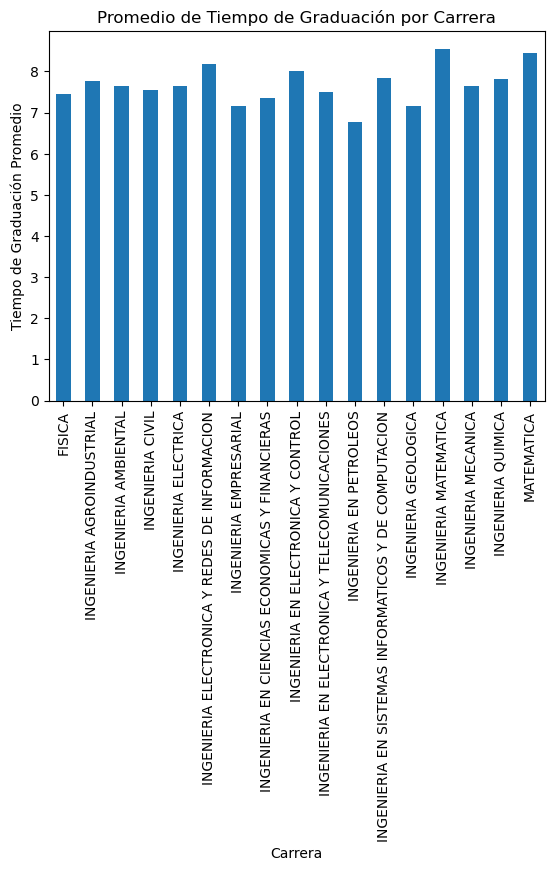

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
agrupado = clean_info.groupby(['CARRERA'])
grupos = agrupado.groups
for grupo in grupos:
    print(grupo)
    print(agrupado.get_group(grupo)['TiempoGraduación'].mean())
 

agrupado = clean_info.groupby(['CARRERA'])
promedios = agrupado['TiempoGraduación'].mean()

# Crear el gráfico de barras
fig, ax = plt.subplots()
promedios.plot(kind='bar', ax=ax)

# Personalizar el gráfico
ax.set_xlabel('Carrera')
ax.set_ylabel('Tiempo de Graduación Promedio')
ax.set_title('Promedio de Tiempo de Graduación por Carrera')

# Mostrar el gráfico
#plt.show()
    

In [68]:
print ("hola")

import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import f_oneway


# Agrupar los datos por carrera
agrupado = clean_info.groupby('CARRERA')

# Calcular el tiempo de graduación promedio para cada grupo
tiempos_promedio = agrupado['TiempoGraduación'].mean()

clean_info['TiempoGraduación'] = pd.to_numeric(clean_info['TiempoGraduación'], errors='coerce')

# Obtener los nombres de las carreras (grupos) y los tiempos promedio correspondientes
carreras = tiempos_promedio.index
tiempos = tiempos_promedio.values

# Crear un DataFrame con los resultados
data = pd.DataFrame({'Carrera': carreras, 'Tiempo de Graduación Promedio': tiempos})

# Imprimir el DataFrame
print(data)

# Realizar el análisis de varianza (ANOVA)
grupos = [agrupado.get_group(grupo)['TiempoGraduación'].values for grupo in agrupado.groups]
stat, p_value = f_oneway(*grupos)

print('Estadística F:', stat)
print('Valor p:', p_value)


hola
                                              Carrera  \
0                                              FISICA   
1                           INGENIERIA AGROINDUSTRIAL   
2                                INGENIERIA AMBIENTAL   
3                                    INGENIERIA CIVIL   
4                                INGENIERIA ELECTRICA   
5       INGENIERIA ELECTRONICA Y REDES DE INFORMACION   
6                              INGENIERIA EMPRESARIAL   
7     INGENIERIA EN CIENCIAS ECONOMICAS Y FINANCIERAS   
8                 INGENIERIA EN ELECTRONICA Y CONTROL   
9      INGENIERIA EN ELECTRONICA Y TELECOMUNICACIONES   
10                            INGENIERIA EN PETROLEOS   
11  INGENIERIA EN SISTEMAS INFORMATICOS Y DE COMPU...   
12                               INGENIERIA GEOLOGICA   
13                              INGENIERIA MATEMATICA   
14                                INGENIERIA MECANICA   
15                                 INGENIERIA QUIMICA   
16                        

C:\Users\nuyaguari\AppData\Local\Temp\ipykernel_14732\822622971.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_info['TiempoGraduación'] = pd.to_numeric(clean_info['TiempoGraduación'], errors='coerce')


                                              Carrera  Desviación Estándar
0                                              FISICA             1.613246
1                           INGENIERIA AGROINDUSTRIAL             0.878204
2                                INGENIERIA AMBIENTAL             1.008208
3                                    INGENIERIA CIVIL             1.236033
4                                INGENIERIA ELECTRICA             1.349136
5       INGENIERIA ELECTRONICA Y REDES DE INFORMACION             1.150082
6                              INGENIERIA EMPRESARIAL             1.308877
7     INGENIERIA EN CIENCIAS ECONOMICAS Y FINANCIERAS             1.286291
8                 INGENIERIA EN ELECTRONICA Y CONTROL             1.490712
9      INGENIERIA EN ELECTRONICA Y TELECOMUNICACIONES             1.178511
10                            INGENIERIA EN PETROLEOS             1.480644
11  INGENIERIA EN SISTEMAS INFORMATICOS Y DE COMPU...             1.857056
12                       

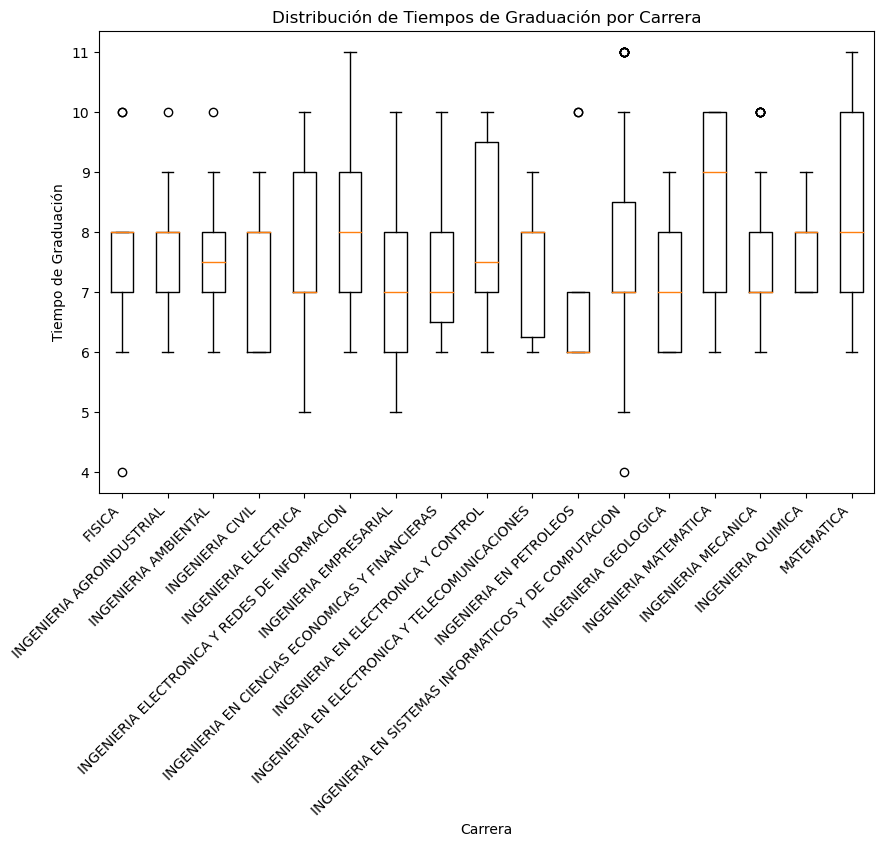

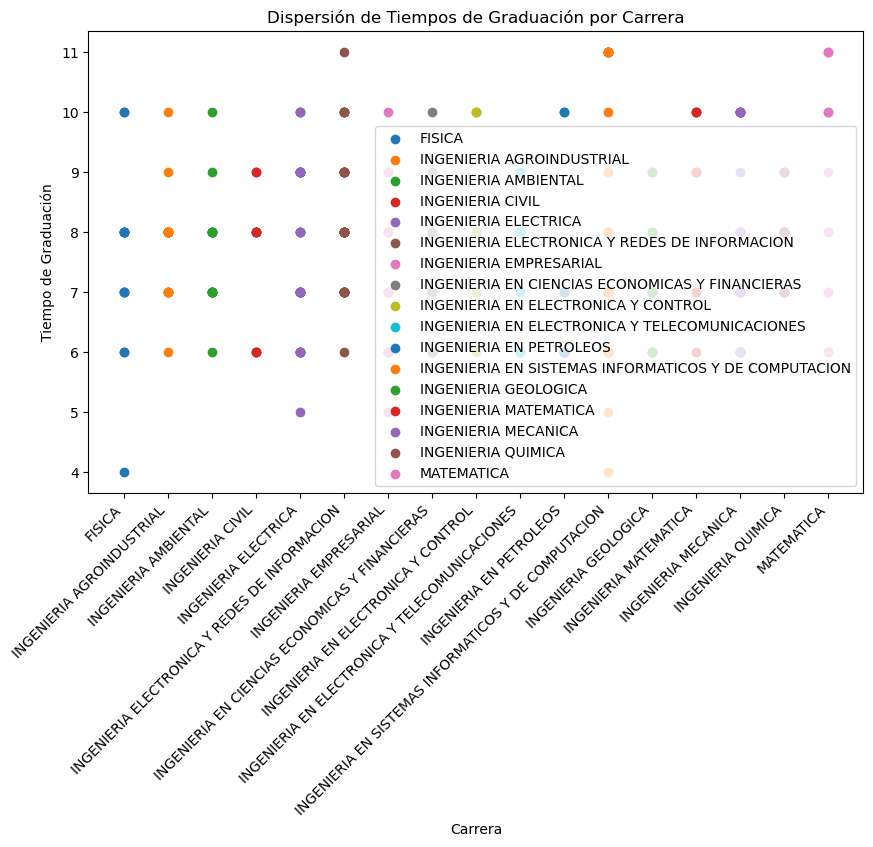

In [69]:
import matplotlib.pyplot as plt
import pandas as pd

# Agrupar los datos por carrera
agrupado = clean_info.groupby('CARRERA')

# Calcular la desviación estándar para cada grupo
desviacion = agrupado['TiempoGraduación'].std()

# Obtener los nombres de las carreras (grupos) y las desviaciones estándar correspondientes
carreras = desviacion.index
desviaciones = desviacion.values

# Crear un DataFrame con los resultados
data = pd.DataFrame({'Carrera': carreras, 'Desviación Estándar': desviaciones})

# Imprimir el DataFrame
print(data)

# Diagrama de caja y bigotes
plt.figure(figsize=(10, 6))
plt.boxplot([agrupado.get_group(grupo)['TiempoGraduación'] for grupo in agrupado.groups], labels=carreras)
plt.xlabel('Carrera')
plt.ylabel('Tiempo de Graduación')
plt.title('Distribución de Tiempos de Graduación por Carrera')
plt.xticks(rotation=45, ha='right')
plt.show()

# Gráfico de dispersión
plt.figure(figsize=(10, 6))
for grupo in agrupado.groups:
    x = [grupo] * len(agrupado.get_group(grupo))
    y = agrupado.get_group(grupo)['TiempoGraduación']
    plt.scatter(x, y, label=grupo)
plt.xlabel('Carrera')
plt.ylabel('Tiempo de Graduación')
plt.title('Dispersión de Tiempos de Graduación por Carrera')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.show()

